In [1]:
#| default_exp attention

In [2]:
#| export
import math, torch
from datasets.load import load_dataset
import fastcore.all as fc
from pathlib import Path
from functools import partial
from fastprogress import progress_bar
import matplotlib.pyplot as plt
from torch.utils.data import default_collate,DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib as mpl
from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.resnet import *

from torch.optim import lr_scheduler

import torch.nn as nn

import torch.optim

In [3]:
conv??

Signature: conv(in_channels, out_channels, kernel_size=3, stride=2, act=True)
Source:   
def conv(in_channels, out_channels, kernel_size=3, stride=2, act=True):
    '''
    Note on convolution layers that change number of channels. Each output channel has a different
    kernel corresponding to each of I input layers. The results of those I convolutions are combined
    (for instance by adding, or averaging) to form the convolution result for that channel. Hence
    the parameters shape for a conv layer with O output channels, I input channels, and K*K kernel is
    (O, I, K, K) - in other words, "each output channel O has I kernels of size (K,K)".
    
    If bias is present (true by default) there will be another parameter tensor, of rank 1, which
    is shape (out_channels). There will be one bias per output channel which broadcasts to add
    to the entire channel tensor.

    '''
    res = nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=kernel_size, padding=kernel_

In [4]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
#| export
'''
continous noise on cosine schedule
'''
def abar(t):
    return (t*math.pi / 2).cos()**2

def inv_abar(x):
    return x.sqrt().acos() * 2/math.pi

def noisify(x0):
    dev = x0.device
    t = torch.rand((x0.shape[0],), device=dev).clamp(0,0.999)
    noise=torch.randn_like(x0)
    abar_t=abar(t)[:,None, None, None]
    x_t = abar_t.sqrt() * x0 + (1-abar_t).sqrt() * noise
    return (x_t, t,), noise

def collate_noised(batch):
    return noisify(default_collate(batch)['image'])

def dl(dataset, bs, collate_fn=collate_noised):
    return DataLoader(dataset, batch_size=bs, collate_fn=collate_fn, num_workers=4)


In [7]:
bs = 512
@inplace
def transformi(b):
    b['image'] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2)) - 0.5 for o in b['image']]

transformed_ds = dsd.with_transform(transformi)
dls = DataLoaders(dl(transformed_ds['train'], bs), dl(transformed_ds['test'], bs))

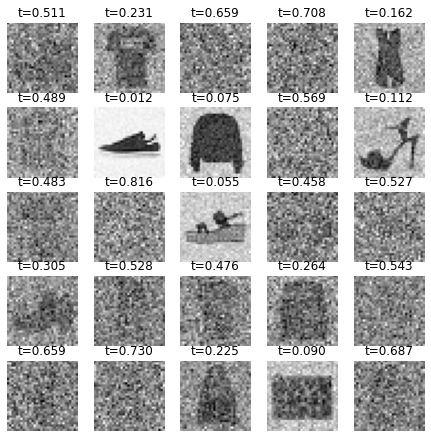

In [8]:
xb,yb=next(iter(dls.train))

show_images(xb[0][:25],titles=[f't={t:.3f}' for t in xb[1]], imsize=1.5)

In [9]:
#| export
def timestep_embedding(timesteps, emb_dim, max_period=10_000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim //2, device = timesteps.device)
    emb = timesteps[:, None].float() * exponent.exp()[None, :]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    if emb_dim % 2 == 1:
        emb = F.pad(emb, (0, 1, 0, 0))
    
    return emb

In [10]:
#| export
'''
conv with pre-activation
'''
def pre_conv(in_channels, out_channels, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm:
        layers.append(norm(in_channels))
    
    if act:
        layers.append(act())
    
    layers.append(nn.Conv2d(in_channels, out_channels, ks, stride, bias=bias, padding=ks//2))
    return layers

In [11]:
#| export
'''
Upscale by factor of 2 and do a convolution
'''
def upsample_and_conv(channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2.0),
        nn.Conv2d(channels, channels, 3, padding=1) # 1 == (ks=3)//2
    )

In [12]:
#| export
def lin(n_inp, n_out, act=nn.SiLU, norm=None, bias=True):
    layers= nn.Sequential()
    if norm:
        layers.append(norm(n_inp))
    
    if act:
        layers.append(act())
    
    layers.append(nn.Linear(n_inp, n_out, bias=bias))
    return layers

In [13]:
def _to_heads(tsr, n_heads):
    'n s c -> n*h s c/h'
    n, s, c = tsr.shape
    return tsr.transpose(1,2).reshape(n*n_heads, c//n_heads, s).transpose(1,2)

def _to_batch(tsr, n_heads):
    n, s, c = tsr.shape
    return tsr.transpose(1, 2).reshape(n//n_heads, c*n_heads, s).transpose(1,2)

In [14]:
t=torch.randn((4, 32*32, 8))
headed=_to_heads(t,4)
batched=_to_batch(headed, 4)
t.shape,headed.shape, batched.shape, t.equal(batched)

(torch.Size([4, 1024, 8]),
 torch.Size([16, 1024, 2]),
 torch.Size([4, 1024, 8]),
 True)

In [15]:
#| export
class SelfAttention2D(nn.Module):
    def __init__(self, channels, channels_per_head):
        super().__init__()
        self.n_heads = channels//channels_per_head
        self.q = lin(channels, channels)
        self.k = lin(channels, channels)
        self.v = lin(channels, channels)
        '''
        If Q_x and K_x matrices (size = (pixels, channels_per_head)) both have 0 mean unit variance, by property of adding variances,
        the output will have variance=channels_per_head and std=sqrt(channels_per_head). Divide result by std to make result have
        std=1. Helps preserve balance of values before taking softmax so some values don't predominate.
        '''
        self.scale = math.sqrt(channels_per_head)
        self.last_lin = lin(channels, channels)
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):
        n, c, h, w = x.shape
        x=x.view(n, c, h*w).transpose(1,2)
        x=self.norm(x)
        q_x=self.q(x)
        k_x=self.k(x)
        v_x=self.v(x)
        x=self._to_heads(x)
        q_x,k_x,v_x = map(self._to_heads, (q_x, k_x, v_x))
        s = (q_x @ k_x.transpose(1, 2)) / self.scale
        s = s.softmax(dim=-1)
        result = s @ v_x
        result = self._to_batch(result)
        
        # we're doing skip connection outside of attention block, not inside it.
        return self.last_lin(result).view(n, c, h, w)
    
    def _to_heads(self, tsr):
        n, s, c = tsr.shape
        return tsr.transpose(1,2).reshape(n*self.n_heads, c//self.n_heads, s).transpose(1,2)
    
    def _to_batch(self, tsr):
        n, s, c = tsr.shape
        return tsr.transpose(1, 2).reshape(n//self.n_heads, c*self.n_heads, s).transpose(1,2)

In [16]:
attn = SelfAttention2D(32, 4)

x=torch.randn((100, 8*8, 32))
x.shape

torch.Size([100, 64, 32])

In [17]:
xh=attn._to_heads(x)
xh.shape

torch.Size([800, 64, 4])

In [18]:
xb=attn._to_batch(xh)
xb.shape

torch.Size([100, 64, 32])

In [19]:
x2=torch.randn((100,32,8,8))
attn(x2).shape

torch.Size([100, 32, 8, 8])

In [20]:
#| export
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, in_channels, out_channels, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d, channels_per_attn_head=0):
        super().__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        
        # half the result of this will be used to scale, the other half to shift
        self.emb_lin = nn.Linear(n_emb, out_channels * 2)
        self.conv1 = pre_conv(in_channels, out_channels, ks, act=act, norm=norm)
        self.conv1.in_channels = in_channels
        self.conv1.out_channels = out_channels
        self.conv2 = pre_conv(out_channels, out_channels, ks, act=act, norm=norm)
        
        # This block not used for up- or down- sampling, but can change channel count, hence the possible idconv
        self.idconv = fc.noop if in_channels==out_channels else nn.Conv2d(out_channels, out_channels, 1)
        
        if channels_per_attn_head > 0:
            self.attn_layer = SelfAttention2D(out_channels, channels_per_attn_head)
        else:
            self.attn_layer = None
    
    def forward(self, x, emb):
        inp = x
        # import pdb; pdb.set_trace()
        x=self.conv1(x)
        t_emb=self.emb_lin(F.silu(emb))
        scale,shift = torch.chunk(t_emb[:, :, None, None], 2, dim=1)
        x= x*(1+scale) + shift
        x=self.conv2(x)
        
        # The first residual
        x=x+self.idconv(x)
        
        if self.attn_layer:
            # a second residual layer dedicated to attention
            x=x + self.attn_layer(x)
        return x
        

In [21]:
#| export
def saved(module, block, save_in=False):
    fwd = module.forward
    
    # is this annotation needed?
    # @wraps(module.forward)
    def _f(*args, **kwargs):
        out = fwd(*args, **kwargs)
        
        block.saved_out.append(out)
        
        # saved input only for debugging purposes
        if save_in:
            block.saved_in.append(args[0])
        return out
    
    module.forward = _f
    return module

In [22]:
#| export

class DownBlock(nn.Module):
    def __init__(self, n_t_emb, in_channels, out_channels, is_final_down=False, num_layers=1, channels_per_head=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        # make EmbResNets
        self.erbs = []
        for i in range(0, num_layers):
            # first erb expands channels, subsequent ones keep it constant
            erb_in_channels = in_channels if i==0 else out_channels
            erb=EmbResBlock(n_t_emb, erb_in_channels, out_channels, channels_per_attn_head=channels_per_head)
            self.erbs.append(saved(erb, self))
        self.erbs = nn.ModuleList(self.erbs)
        
        # only downsample if not the final downblock
        self.is_final_down=is_final_down
        if not self.is_final_down:
            kernel_size=3
            down_conv = nn.Conv2d(out_channels, out_channels, kernel_size, stride=2, padding=kernel_size//2)
            self.down_conv = saved(down_conv, self)
        else:
            self.down_conv = None
            
    def forward(self, x, emb):
        # saved io only needed during scope of a single forward pass through module. The next time
        # forward is called will be the next minibatch at which the data needs to be reset.
        self.saved_in=[]
        self.saved_out=[]
        for erb in self.erbs:
            x = erb(x, emb)
        
        if not self.is_final_down:
            x = self.down_conv(x)
        
        return x

In [23]:
#| export
class UpBlock(nn.Module):
    def __init__(self, n_t_emb, prev_block_out_chans, skip_in_channels_ls, out_channels, is_final_up=False, num_layers=1, channels_per_head=0):
        super().__init__()
        self.in_channels = prev_block_out_chans
        self.out_channels = out_channels
        
        num_layers = len(skip_in_channels_ls)
        
        # make EmbResNets
        self.erbs = []
        for i in range(0, num_layers):
            
            '''
            if first erb in block, then data coming upward through the block will have come from the previous block
            
            otherwise will be from the last erb in *this* block
            '''
            if i==0:
                upward_in_channels=prev_block_out_chans
            else:
                upward_in_channels=out_channels
                
            '''
            skip connection is input concatenated on the channel dimension, so each erb must take channels
            equal to those from the data being passed up plus those from the data being concatenated onto it
            '''
            erb_in_channels = upward_in_channels + skip_in_channels_ls[i]
            erb=EmbResBlock(n_t_emb, erb_in_channels, out_channels, channels_per_attn_head=channels_per_head)
            self.erbs.append(saved(erb, self))
        self.erbs = nn.ModuleList(self.erbs)
        
        # only upsample if not the final upblock
        self.is_final_up=is_final_up
        if not self.is_final_up:
            up_conv = upsample_and_conv(out_channels)
            self.up_conv = saved(up_conv, self)
        else:
            self.up_conv = None
            
    def forward(self, x, emb, skip_conns):
        self.saved_in=[]
        self.saved_out=[]
        for erb in self.erbs:
            x = erb(torch.cat([x, skip_conns.pop()], dim=1), emb)
        
        if not self.is_final_up:
            x = self.up_conv(x)
        return x

In [24]:
import torch.optim as optim
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.accel import *

In [27]:
#| export
class EmbUNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, block_channel_counts=(32,64, 128, 256), num_layers=1, channels_per_head=8, attn_start=1):
        super().__init__()
        # in conv
        self.first_conv = conv(in_channels, block_channel_counts[0], stride=1, act=False)
        self.first_conv.in_channels=in_channels
        self.first_conv.out_channels=block_channel_counts[0]
        
        # timestep embedding
        '''
        length of embedding produced by initial timestep embedding
        only used to produce transformed t embeddings
        '''
        self.t_emb_sz = block_channel_counts[0]
        
        '''
        length of embedding after being transformed by an MLP to be passed in to all ERBs in all 
        down and up blocks
        '''
        final_emb_sz = self.t_emb_sz * 4
        
        self.emb_mlp = nn.Sequential(lin(self.t_emb_sz, final_emb_sz, norm=nn.BatchNorm1d),
                                  lin(final_emb_sz, final_emb_sz))
        
        # down blocks
        num_blocks = len(block_channel_counts)
        final=False
        self.downblocks = []
        down_in_channels = block_channel_counts[0]
        for i in range(num_blocks):
            if i==num_blocks - 1:
                final = True
            down_out_channels = block_channel_counts[i]
            erb_channels_per_head = channels_per_head if i >= attn_start else 0
            block = DownBlock(final_emb_sz, down_in_channels, down_out_channels, final, num_layers, erb_channels_per_head)
            down_in_channels=down_out_channels
                              
            self.downblocks.append(block)
            
        self.downblocks = nn.ModuleList(self.downblocks)
        
        # mid block
        self.midblock = EmbResBlock(final_emb_sz, block_channel_counts[-1], block_channel_counts[-1], channels_per_attn_head=channels_per_head)
        
        # up blocks
        
        '''
        calculate the channels of skip connections:
        
        start with a single entry of first channel block size (output of first_conv)
        
        subsequently for all but last downblock, add (num_layers+1) copies of corresponding channel count for block,
        for the num_layers of resblock and the 1 downsampling layer, all of which produce the same out_channels
        
        finally add num_layers copies of the final block channel_out, because last downblock has no downsampling
        
        length of list will be, therefore, 1 + (num_blocks-1)*(num_layers+1) + num_layers = num_blocks*(num_layers+1),
        with (num_layers+1) being the number of skip connections going into each upblock
        '''
        skip_conn_channels=[block_channel_counts[0]]
        for i in range(num_blocks - 1):
            skip_conn_channels = skip_conn_channels + (num_layers+1) * [block_channel_counts[i]]
        skip_conn_channels = skip_conn_channels + num_layers * [block_channel_counts[-1]]
        
        skips_per_block = num_layers+1
        skip_conn_channels = list(reversed(skip_conn_channels))
        skip_conn_channels = [skip_conn_channels[i: i+skips_per_block] for i in range(0, len(skip_conn_channels), skips_per_block)]
        self.skip_conn_channels = skip_conn_channels
            
        prev_channels = block_channel_counts[-1]
        final = False
        self.upblocks=[]
        for i in range(num_blocks):
            if i==num_blocks-1:
                final = True
            
            erb_channels_per_head = channels_per_head if i < (num_blocks - attn_start) else 0
            up_out_channels=block_channel_counts[-(i+1)]
            block = UpBlock(final_emb_sz, prev_channels, skip_conn_channels[i], up_out_channels, final, num_layers+1, erb_channels_per_head)
            self.upblocks.append(block)
            prev_channels = up_out_channels
        
        self.upblocks = nn.ModuleList(self.upblocks)
        
        # last conv
        self.last_conv= pre_conv(block_channel_counts[0], out_channels, stride=1, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)
        self.last_conv.in_channels = block_channel_counts[0]
        self.last_conv.out_channels = out_channels
    def forward(self, inp):
        x, t = inp
        t_emb = timestep_embedding(t, self.t_emb_sz)
        generic_emb = self.emb_mlp(t_emb)
        x = self.first_conv(x)
        skip_conns = [x]
        for block in self.downblocks:
            x = block(x, generic_emb)
            skip_conns = skip_conns + block.saved_out
        
        x = self.midblock(x, generic_emb)
        
        for block  in self.upblocks:
            x = block(x, generic_emb, skip_conns)
        
        return self.last_conv(x)
        

In [28]:
from diy_stable_diffusion.init import clean_mem

In [29]:
lin??

Signature:
lin(
    n_inp,
    n_out,
    act=<class 'torch.nn.modules.activation.SiLU'>,
    norm=None,
    bias=True,
)
Docstring: <no docstring>
Source:   
def lin(n_inp, n_out, act=nn.SiLU, norm=None, bias=True):
    layers= nn.Sequential()
    if norm:
        layers.append(norm(n_inp))
    
    if act:
        layers.append(act())
    
    layers.append(nn.Linear(n_inp, n_out, bias=bias))
    return layers
File:      /tmp/ipykernel_701/2542287320.py
Type:      function


# END of model code

In [39]:
del(learn.model)
del(model)
del(learn)

In [40]:
clean_mem()

In [37]:
bs = 512
@inplace
def transformi(b):
    b['image'] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2)) - 0.5 for o in b['image']]

transformed_ds = dsd.with_transform(transformi)
dls = DataLoaders(dl_noised(transformed_ds['train'], bs), dl_noised(transformed_ds['test'], bs))

below results:
params bs=512, 118 batches per epoch, attention disabled

    loss 	epoch 	train
    0.167 	0 	train
    0.312 	0 	eval
    0.073 	1 	train
    0.098 	1 	eval
    0.060 	2 	train
    0.071 	2 	eval
    0.053 	3 	train
    0.064 	3 	eval

Results from Jeremy's notebook (taken from github), WITH attention.:

    loss 	epoch 	train
    0.150 	0 	train
    0.086 	0 	eval
    0.069 	1 	train
    0.171 	1 	eval
    0.057 	2 	train
    0.071 	2 	eval
    0.050 	3 	train
    0.055 	3 	ev
    ...
    finalized at:
    0.032 	24 	train
    0.033 	24 	eva

Results from Jeremy's notebook, my modification to remove attention (attn_chans=0):

    loss 	epoch 	train
    0.162 	0 	train
    0.088 	0 	eval
    0.067 	1 	train
    0.094 	1 	eval
    
Takeaway: without attention, my model starts off at least with comparable performance to Jeremy's model both with and without attention.

Jeremy's model without attention, I cancelled it at

In [ ]:
'''
attention disabled
'''
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2, channels_per_head=0)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)

Note: clean_mem doesn't work, have to restart kernel after cuda out of mem exception still

First run of below, bs=128, got result:

    loss 	epoch 	train
    0.098 	0 	train
    0.064 	0 	eval

Comparable (better) to Jeremy's nb, with attention.

In [29]:
bs = 128
@inplace
def transformi(b):
    b['image'] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2)) - 0.5 for o in b['image']]

transformed_ds = dsd.with_transform(transformi)
dls = DataLoaders(dl_noised(transformed_ds['train'], bs), dl_noised(transformed_ds['test'], bs))

In [ ]:
'''
attention enabled, bs=128

Note: this is after fixing bug which disregarded attn_start and put
attention into all layers
'''
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)

bs of 512 and 256 definitively don't work, tried both options below each on fresh kernel restart and after fixing attn_chans
bug, both times CUDA OOM

In [30]:
bs = 512
@inplace
def transformi(b):
    b['image'] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2)) - 0.5 for o in b['image']]

transformed_ds = dsd.with_transform(transformi)
dls = DataLoaders(dl_noised(transformed_ds['train'], bs), dl_noised(transformed_ds['test'], bs))

In [ ]:
'''
attention enabled, bs=512

still gets CUDA OOM, after fresh kernel restart and fixing bug with attn_start in UNet
'''
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)
torch.save(model, 'models/2024-01-23-embunetattn-ndiucbq.pkl')

In [29]:
bs = 256
@inplace
def transformi(b):
    b['image'] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2)) - 0.5 for o in b['image']]

transformed_ds = dsd.with_transform(transformi)
dls = DataLoaders(dl_noised(transformed_ds['train'], bs), dl_noised(transformed_ds['test'], bs))

In [ ]:
'''
attention enabled, bs=256

'''
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)
torch.save(model, 'models/2024-01-23-embunetattn-bs256-ndiucbq.pkl')

Now again try bs=128 and go to lunch and save it hopefully

In [29]:
bs = 128
@inplace
def transformi(b):
    b['image'] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2)) - 0.5 for o in b['image']]

transformed_ds = dsd.with_transform(transformi)
dls = DataLoaders(dl_noised(transformed_ds['train'], bs), dl_noised(transformed_ds['test'], bs))

result

    loss 	epoch 	train
    0.097 	0 	train
    0.062 	0 	eval
    0.054 	1 	train
    0.051 	1 	eval
    0.046 	2 	train
    0.044 	2 	eval
    0.043 	3 	train
    0.044 	3 	eval
    0.041 	4 	train
    0.040 	4 	eval
    0.040 	5 	train
    0.042 	5 	eval
    0.039 	6 	train
    0.046 	6 	eval
    0.038 	7 	train
    0.042 	7 	eval
    0.037 	8 	train
    0.036 	8 	eval
    0.037 	9 	train
    0.039 	9 	eval
    0.036 	10 	train
    0.037 	10 	eval
    0.035 	11 	train
    0.037 	11 	eval
    0.036 	12 	train
    0.043 	12 	eval
    0.035 	13 	train
    0.038 	13 	eval
    0.034 	14 	train
    0.043 	14 	eval
    0.034 	15 	train
    0.036 	15 	eval
    0.034 	16 	train
    0.038 	16 	eval
    0.034 	17 	train
    0.033 	17 	eval
    0.033 	18 	train
    0.036 	18 	eval
    0.033 	19 	train
    0.034 	19 	eval
    0.033 	20 	train
    0.032 	20 	eval
    0.032 	21 	train
    0.033 	21 	eval
    0.032 	22 	train
    0.032 	22 	eval
    0.032 	23 	train
    0.032 	23 	eval
    0.032 	24 	train
    0.033 	24 	eval

Cannot save due to pickle issue, "AttributeError: Can't pickle local object 'saved.<locals>._f"

loss,epoch,train
0.097,0,train
0.062,0,eval
0.054,1,train
0.051,1,eval
0.046,2,train
0.044,2,eval
0.043,3,train
0.044,3,eval
0.041,4,train
0.040,4,eval


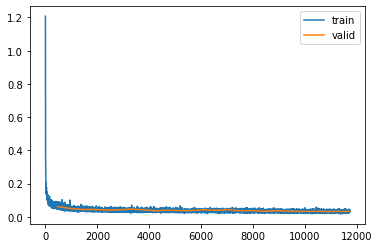

AttributeError: Can't pickle local object 'saved.<locals>._f'

In [30]:
'''
attention enabled, bs=128

'''
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)
torch.save(model, 'models/2024-01-23-embunetattn-bs128-cskjnei.pkl')

# Model saving
Can save and load state_dict to get around "local object" issue for the "saved()" wrapper function
model2.load_state_dict(torch.load('models/2024-01-23-unetattn-statedict-sfojifse.pkl'))

In [32]:
torch.save(list(model.parameters()), 'models/2024-01-23-unetattn-savedparams-ijofsio.pkl')

In [33]:
torch.save(model.state_dict(), 'models/2024-01-23-unetattn-statedict-sfojifse.pkl')

In [34]:
model2 = EmbUNetModel(num_layers=2)

In [35]:
model2.load_state_dict(torch.load('models/2024-01-23-unetattn-statedict-sfojifse.pkl'))

<All keys matched successfully>

loss,epoch,train
0.033,0,eval


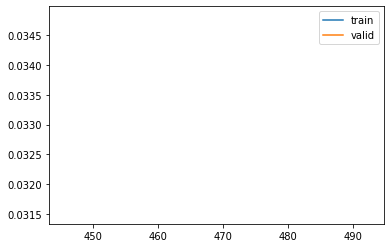

In [38]:
learn = Learner(model2, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(1, do_train=False, do_validate=True)

In [268]:
def io(o):
    return f'in_channels={o.in_channels}, out_channels={o.out_channels}'

def summarize_model(model):
    # in conv
    print('in conv: ' + io(model.first_conv))   
    print()
    
    # erbs with their convs
    for upordown, blocks in zip(['down', 'up'], [model.downblocks, model.upblocks]):
        for i,b in enumerate(blocks):
            print(f'{upordown} {i}: {io(b)}')
            for j,e in enumerate(b.erbs):
                print(f'\t erb {j}: {io(e)}')
        print()
    
    # out conv
    print('out conv: ' + io(model.last_conv))   
    print()
    
    print(list(enumerate(model.skip_conn_channels)))

summarize_model(model)

in conv: in_channels=1, out_channels=32

down 0: in_channels=32, out_channels=32
	 erb 0: in_channels=32, out_channels=32
	 erb 1: in_channels=32, out_channels=32
down 1: in_channels=32, out_channels=64
	 erb 0: in_channels=32, out_channels=64
	 erb 1: in_channels=64, out_channels=64
down 2: in_channels=64, out_channels=128
	 erb 0: in_channels=64, out_channels=128
	 erb 1: in_channels=128, out_channels=128
down 3: in_channels=128, out_channels=256
	 erb 0: in_channels=128, out_channels=256
	 erb 1: in_channels=256, out_channels=256

up 0: in_channels=256, out_channels=256
	 erb 0: in_channels=512, out_channels=256
	 erb 1: in_channels=512, out_channels=256
	 erb 2: in_channels=384, out_channels=256
up 1: in_channels=256, out_channels=128
	 erb 0: in_channels=384, out_channels=128
	 erb 1: in_channels=256, out_channels=128
	 erb 2: in_channels=192, out_channels=128
up 2: in_channels=128, out_channels=64
	 erb 0: in_channels=192, out_channels=64
	 erb 1: in_channels=128, out_channels=64

loss,epoch,train
0.994,0,eval


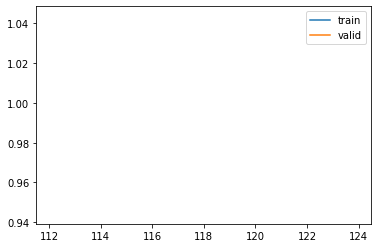

In [172]:
with torch.no_grad():
    learn.fit(1, do_train=False, do_validate=True)

In [176]:
list(enumerate([s.shape for down in model.downblocks for s in down.saved_out]))

[(0, torch.Size([272, 32, 32, 32])),
 (1, torch.Size([272, 32, 32, 32])),
 (2, torch.Size([272, 32, 16, 16])),
 (3, torch.Size([272, 64, 16, 16])),
 (4, torch.Size([272, 64, 16, 16])),
 (5, torch.Size([272, 64, 8, 8])),
 (6, torch.Size([272, 128, 8, 8])),
 (7, torch.Size([272, 128, 8, 8])),
 (8, torch.Size([272, 128, 4, 4])),
 (9, torch.Size([272, 256, 4, 4])),
 (10, torch.Size([272, 256, 4, 4]))]

In [178]:
list(enumerate([s.shape for up in model.upblocks for s in up.saved_out]))

[(0, torch.Size([272, 256, 4, 4])),
 (1, torch.Size([272, 256, 4, 4])),
 (2, torch.Size([272, 256, 4, 4])),
 (3, torch.Size([272, 256, 8, 8])),
 (4, torch.Size([272, 128, 8, 8])),
 (5, torch.Size([272, 128, 8, 8])),
 (6, torch.Size([272, 128, 8, 8])),
 (7, torch.Size([272, 128, 16, 16])),
 (8, torch.Size([272, 64, 16, 16])),
 (9, torch.Size([272, 64, 16, 16])),
 (10, torch.Size([272, 64, 16, 16])),
 (11, torch.Size([272, 64, 32, 32])),
 (12, torch.Size([272, 32, 32, 32])),
 (13, torch.Size([272, 32, 32, 32])),
 (14, torch.Size([272, 32, 32, 32]))]

In [35]:
#|export 
def ddim_step(xt, noise, abar_t, abar_tm1, bbar_t, bbar_tm1, eta, sigma, clamp=True):
    sigma = ((bbar_tm1 / bbar_t).sqrt() * (bbar_t / abar_tm1).sqrt()) * eta
    '''
    image as derived from predicted noise
    '''
    x0hat = (xt - noise*bbar_t.sqrt()) / abar_t.sqrt() 
    
    if clamp:
        x0hat = x0hat.clamp(-1, 1)
        
    if bbar_tm1 <= sigma**2 + 0.01:
        sigma = 0.0
    
    xt = abar_tm1.sqrt() * x0hat + (bbar_tm1 - sigma**2).sqrt() * noise
    xt += sigma * torch.randn(xt.shape).to(xt.device)
    
    return x0hat, xt

In [36]:
#|export
def sample(denoise_fn, denoise_mdl, sz, steps, eta=1., clamp=True):
    denoise_mdl.eval()
    xt = torch.randn(sz).cuda()
    step_sz = 1/steps
    ts = torch.linspace(1-step_sz, 0, steps).cuda()
    for i,t in enumerate(progress_bar(ts)):
        with torch.no_grad():
            pred_noise = denoise_mdl((xt, t[None]))
            abar_t=abar(t)
            abar_tm1=abar(t - step_sz) if t >= step_sz else torch.tensor(1).cuda()
            x0hat, xt = denoise_fn(xt, pred_noise, abar_t, abar_tm1, 1-abar_t, 1-abar_tm1, eta, 1-((i+1)/100), clamp=clamp)
    return x0hat.float().cpu()
        

In [138]:
'''
100 steps
'''
preds = sample(ddim_step, model2, (25, 1, 32, 32), steps=100, eta=1.)
s = (preds*2)
s.min(), s.max()

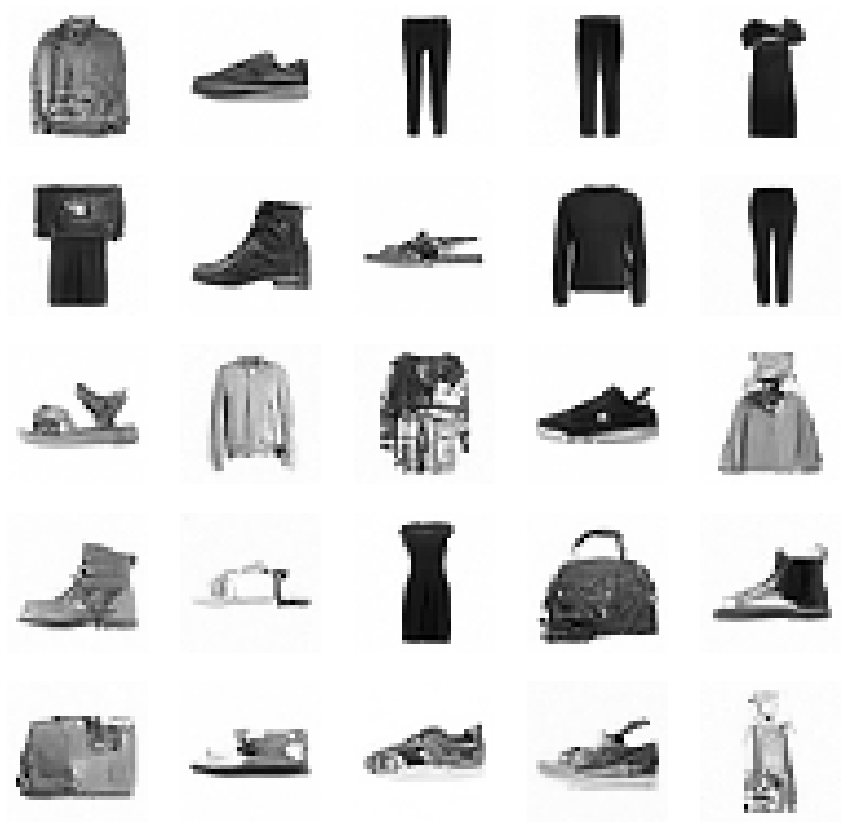

In [139]:
show_images(s)

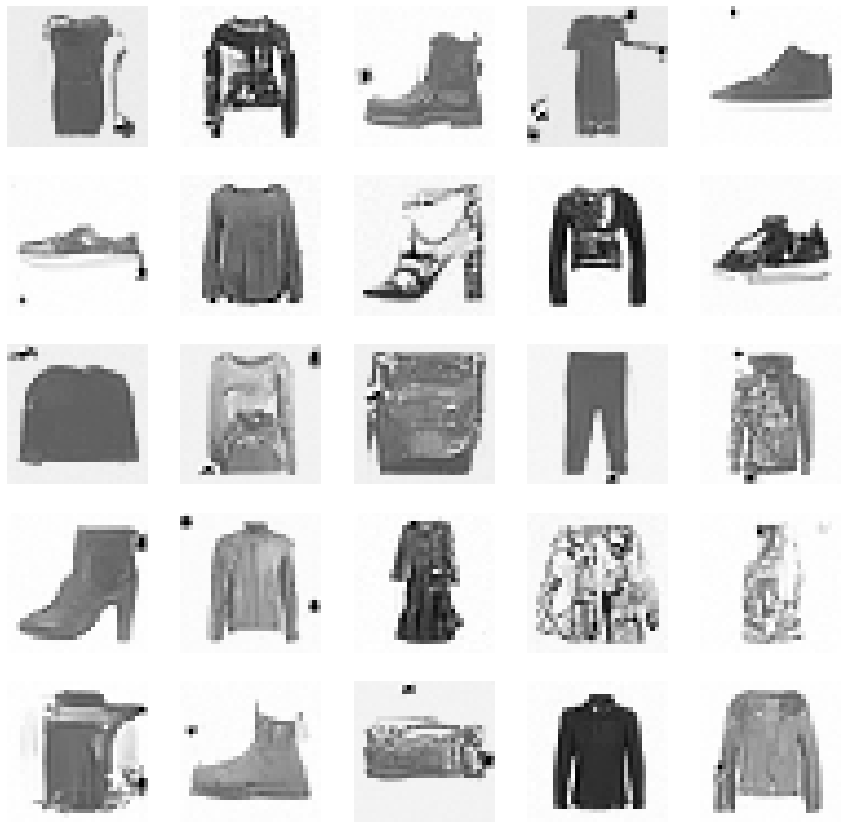

In [121]:
'''
1000 steps

quite garbage!
'''
preds = sample(ddim_step, model, (25, 1, 32, 32), steps=1000, eta=1.)
s = (preds*2)
show_images(s)

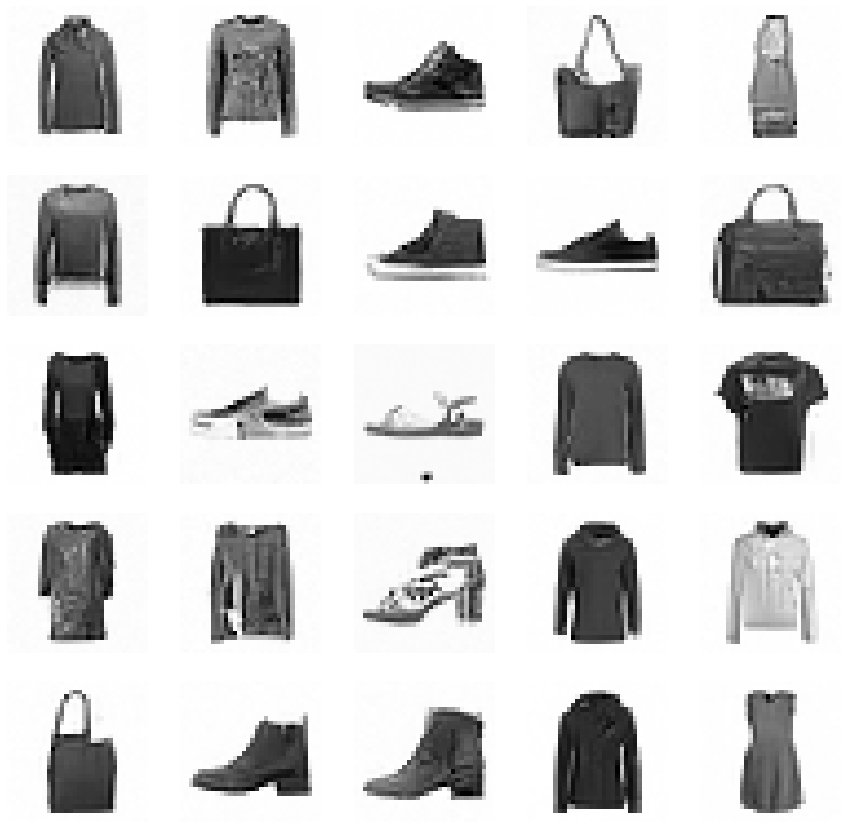

In [122]:
'''
250 steps
'''
preds = sample(ddim_step, model, (25, 1, 32, 32), steps=250, eta=1.)
s = (preds*2)
show_images(s)

# Conditional model

In [25]:
#|export
def diffusion_class_collate(batch):
    batch = default_collate(batch)
    (xt, t), added_noise = noisify(batch['image'])
    return (xt, t, batch['label']), added_noise


In [26]:
bs = 128
@inplace
def transformi(b):
    b['image'] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2)) - 0.5 for o in b['image']]

transformed_ds = dsd.with_transform(transformi)
dls = DataLoaders(dl(transformed_ds['train'], bs, collate_fn=diffusion_class_collate),
                  dl(transformed_ds['test'], bs, collate_fn=diffusion_class_collate))

In [27]:
#| export
class CondEmbUNetModel(nn.Module):
    def __init__(self, num_classes, in_channels=1, out_channels=1, block_channel_counts=(32,64, 128, 256), num_layers=1, channels_per_head=8, attn_start=1):
        super().__init__()
        # in conv
        self.first_conv = conv(in_channels, block_channel_counts[0], stride=1, act=False)
        self.first_conv.in_channels=in_channels
        self.first_conv.out_channels=block_channel_counts[0]
        
        # timestep embedding
        '''
        length of embedding produced by initial timestep embedding
        only used to produce transformed t embeddings
        
        this size doesn't particularly have to match any channel size because it will
        get re-transformed by the MLP
        '''
        self.t_emb_sz = block_channel_counts[0]
        
        '''
        length of embedding to be passed in to all ERBs in all 
        down and up blocks.
        
        This will be the size of the single information embedding which will be the sum
        of the class embedding and the mlp-transformed time-embedding
        '''
        final_emb_sz = self.t_emb_sz * 4
        
        self.t_emb_mlp = nn.Sequential(lin(self.t_emb_sz, final_emb_sz, norm=nn.BatchNorm1d),
                                  lin(final_emb_sz, final_emb_sz))
        
        # class embedding
        '''
        nn.Embedding used because it does one-hot encoding itself, takes an index in forward pass
        and produced embedded vector
        '''
        self.c_emb = nn.Embedding(num_classes, final_emb_sz)
        
        # down blocks
        num_blocks = len(block_channel_counts)
        final=False
        self.downblocks = []
        down_in_channels = block_channel_counts[0]
        for i in range(num_blocks):
            if i==num_blocks - 1:
                final = True
            down_out_channels = block_channel_counts[i]
            erb_channels_per_head = channels_per_head if i >= attn_start else 0
            block = DownBlock(final_emb_sz, down_in_channels, down_out_channels, final, num_layers, erb_channels_per_head)
            down_in_channels=down_out_channels
                              
            self.downblocks.append(block)
            
        self.downblocks = nn.ModuleList(self.downblocks)
        
        # mid block
        self.midblock = EmbResBlock(final_emb_sz, block_channel_counts[-1], block_channel_counts[-1], channels_per_attn_head=channels_per_head)
        
        # up blocks
        
        '''
        calculate the channels of skip connections:
        
        start with a single entry of first channel block size (output of first_conv)
        
        subsequently for all but last downblock, add (num_layers+1) copies of corresponding channel count for block,
        for the num_layers of resblock and the 1 downsampling layer, all of which produce the same out_channels
        
        finally add num_layers copies of the final block channel_out, because last downblock has no downsampling
        
        length of list will be, therefore, 1 + (num_blocks-1)*(num_layers+1) + num_layers = num_blocks*(num_layers+1),
        with (num_layers+1) being the number of skip connections going into each upblock
        '''
        skip_conn_channels=[block_channel_counts[0]]
        for i in range(num_blocks - 1):
            skip_conn_channels = skip_conn_channels + (num_layers+1) * [block_channel_counts[i]]
        skip_conn_channels = skip_conn_channels + num_layers * [block_channel_counts[-1]]
        
        skips_per_block = num_layers+1
        skip_conn_channels = list(reversed(skip_conn_channels))
        skip_conn_channels = [skip_conn_channels[i: i+skips_per_block] for i in range(0, len(skip_conn_channels), skips_per_block)]
        self.skip_conn_channels = skip_conn_channels
            
        prev_channels = block_channel_counts[-1]
        final = False
        self.upblocks=[]
        for i in range(num_blocks):
            if i==num_blocks-1:
                final = True
            
            erb_channels_per_head = channels_per_head if i < (num_blocks - attn_start) else 0
            up_out_channels=block_channel_counts[-(i+1)]
            block = UpBlock(final_emb_sz, prev_channels, skip_conn_channels[i], up_out_channels, final, num_layers+1, erb_channels_per_head)
            self.upblocks.append(block)
            prev_channels = up_out_channels
        
        self.upblocks = nn.ModuleList(self.upblocks)
        
        # last conv
        self.last_conv= pre_conv(block_channel_counts[0], out_channels, stride=1, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)
        self.last_conv.in_channels = block_channel_counts[0]
        self.last_conv.out_channels = out_channels
        
    '''
    Model takes t tensor with a different timestep for each image, shape [batch_size]
    '''
    def forward(self, inp):
        x, t, c = inp
        t_emb = timestep_embedding(t, self.t_emb_sz)
        c_emb = self.c_emb(c)
        '''
        t is "double embedded" first from a
        '''
        generic_emb = self.t_emb_mlp(t_emb) + c_emb
        x = self.first_conv(x)
        skip_conns = [x]
        for block in self.downblocks:
            x = block(x, generic_emb)
            skip_conns = skip_conns + block.saved_out
        
        x = self.midblock(x, generic_emb)
        
        for block  in self.upblocks:
            x = block(x, generic_emb, skip_conns)
        
        return self.last_conv(x)
        

In [128]:
dsd['test'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

Ran once for two epochs but machine was going to autoshutdown soon so restarted machine. First run got:

    loss 	epoch 	train
    0.117 	0 	train
    0.063 	0 	eval
    0.055 	1 	train
    0.054 	1 	eval


loss,epoch,train
0.116,0,train
0.065,0,eval
0.056,1,train
0.053,1,eval
0.047,2,train
0.047,2,eval
0.043,3,train
0.043,3,eval
0.041,4,train
0.041,4,eval


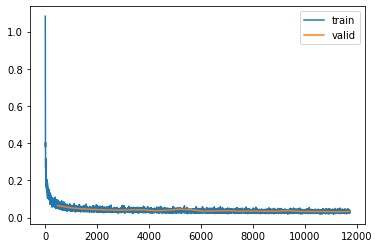

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [33]:
'''
Conditional model!
'''
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = CondEmbUNetModel(10, in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)
torch.save(model.state_dict(), 'models/2024-01-23-condunet-statedict-iuncvih.pkl')

In [30]:
bs, len(dls.train)

(128, 469)

In [31]:
conv??

Signature: conv(in_channels, out_channels, kernel_size=3, stride=2, act=True)
Source:   
def conv(in_channels, out_channels, kernel_size=3, stride=2, act=True):
    '''
    Note on convolution layers that change number of channels. Each output channel has a different
    kernel corresponding to each of I input layers. The results of those I convolutions are combined
    (for instance by adding, or averaging) to form the convolution result for that channel. Hence
    the parameters shape for a conv layer with O output channels, I input channels, and K*K kernel is
    (O, I, K, K) - in other words, "each output channel O has I kernels of size (K,K)".
    
    If bias is present (true by default) there will be another parameter tensor, of rank 1, which
    is shape (out_channels). There will be one bias per output channel which broadcasts to add
    to the entire channel tensor.

    '''
    res = nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=kernel_size, padding=kernel_

In [32]:
lin??

Signature:
lin(
    n_inp,
    n_out,
    act=<class 'torch.nn.modules.activation.SiLU'>,
    norm=None,
    bias=True,
)
Docstring: <no docstring>
Source:   
def lin(n_inp, n_out, act=nn.SiLU, norm=None, bias=True):
    layers= nn.Sequential()
    if norm:
        layers.append(norm(n_inp))
    
    if act:
        layers.append(act())
    
    layers.append(nn.Linear(n_inp, n_out, bias=bias))
    return layers
File:      /tmp/ipykernel_438/2542287320.py
Type:      function


In [33]:
pre_conv??

Signature:
pre_conv(
    in_channels,
    out_channels,
    ks=3,
    stride=1,
    act=<class 'torch.nn.modules.activation.SiLU'>,
    norm=None,
    bias=True,
)
Docstring: <no docstring>
Source:   
def pre_conv(in_channels, out_channels, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm:
        layers.append(norm(in_channels))
    
    if act:
        layers.append(act())
    
    layers.append(nn.Conv2d(in_channels, out_channels, ks, stride, bias=bias, padding=ks//2))
    return layers
File:      /tmp/ipykernel_438/3699106007.py
Type:      function


loss,epoch,train
0.116,0,train
0.065,0,eval
0.056,1,train
0.055,1,eval
0.047,2,train
0.047,2,eval
0.043,3,train
0.047,3,eval
0.041,4,train
0.043,4,eval


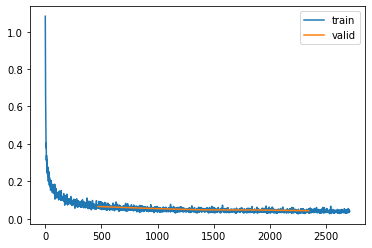

KeyboardInterrupt: 

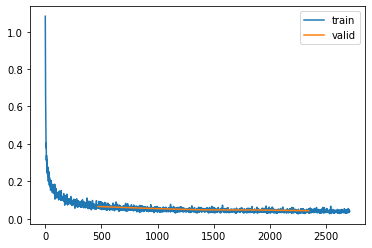

In [28]:
'''
Conditional model... re-run exact same as above cell, 2024-01-30... 48gb A6000... it works well, starting right off the bat with
great MSE loss, 0.065 eval epoch 0. I'm happy about that!
'''
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = CondEmbUNetModel(10, in_channels=1, out_channels=1, block_channel_counts=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)

In [41]:
#|export
def cond_sample(clas, denoise_fn, denoise_mdl, sz, steps, eta=1., clamp=True):
    clas = torch.tensor(clas).cuda()[None]
    denoise_mdl.eval()
    xt = torch.randn(sz).cuda()
    step_sz = 1/steps
    ts = torch.linspace(1-step_sz, 0, steps).cuda()
    for i,t in enumerate(progress_bar(ts)):
        with torch.no_grad():
            pred_noise = denoise_mdl((xt, t[None], clas))
            abar_t=abar(t)
            abar_tm1=abar(t - step_sz) if t >= step_sz else torch.tensor(1).cuda()
            x0hat, xt = denoise_fn(xt, pred_noise, abar_t, abar_tm1, 1-abar_t, 1-abar_tm1, eta, 1-((i+1)/100), clamp=clamp)
    return x0hat.float().cpu()
        

In [61]:
list(enumerate(dsd['test'].features['label'].names))
classes = {v:k for k,v in enumerate(dsd['test'].features['label'].names)}
classes

{'T - shirt / top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

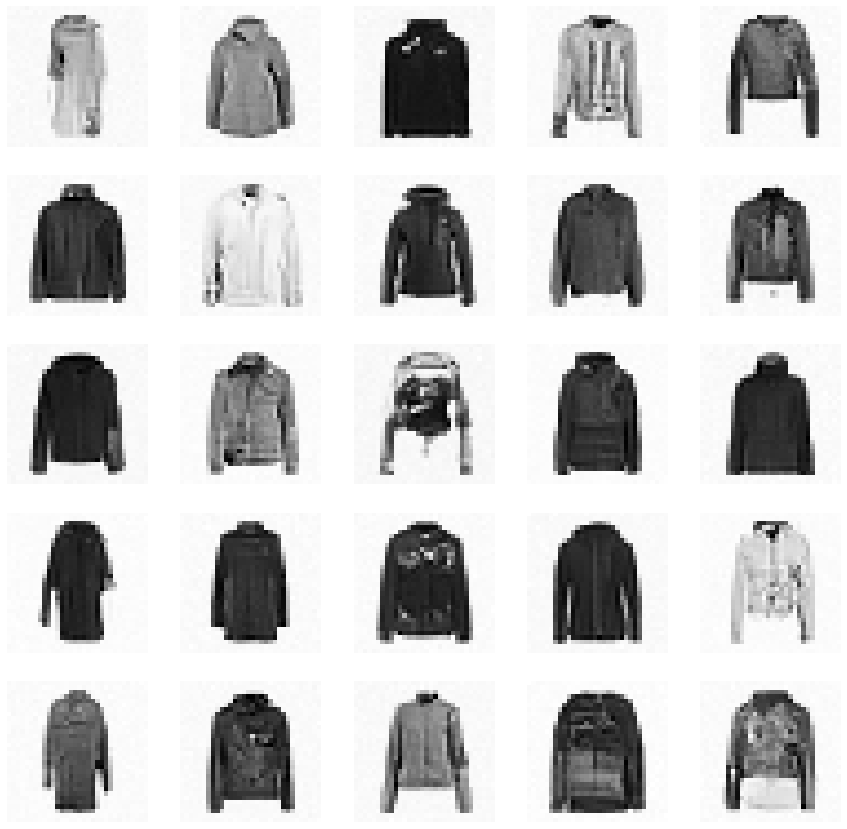

In [64]:
sz=(25, 1, 32, 32)
s=cond_sample(classes['Coat'], ddim_step, model, sz, 100)
show_images(s)

In [1]:
import nbdev; nbdev.nbdev_export()